In [2]:
import  pandas as pd

In [3]:
train = pd.read_csv('Train_0511.csv')


In [4]:
train = train.fillna('')
train.columns = train.columns.str.replace(' ', '') 
train.head()

,EntityName,EntityCode,GAAP,BusinessUnit,Year,Period,Category,UserGLcode,UserGLDescription,LayersinCoA,...,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14,Column15
0,National Insurance,NAI3908,IFRS,,2020,202012-12,NewMappingMCOA,,,BS_GROUP,...,,,,,,,,,,
1,National Insurance,NAI3908,IFRS,,2020,202012-12,NewMappingMCOA,,,BS_GROUP,...,,,,,,,,,,
2,National Insurance,NAI3908,IFRS,,2020,202012-12,NewMappingMCOA,,,BS_GROUP,...,,,,,,,,,,
3,National Insurance,NAI3908,IFRS,,2020,202012-12,NewMappingMCOA,,,BS_GROUP,...,,,,,,,,,,
4,National Insurance,NAI3908,IFRS,,2020,202012-12,NewMappingMCOA,,,BS_GROUP,...,,,,,,,,,,


In [5]:
# Read Columnx and fill rows based on value present at level for all rows

filter_col = [col for col in train if col.startswith('Column')]

for i,col in enumerate(filter_col):
    val=""   
    for index, row in train.iterrows():
        if row[col] != '':
            val=row[col]         
        row[col]=val
        #print(index)

In [6]:
# remove empty description rows
cleantrain = train.loc[train['UserGLDescription'] != ''].copy()


In [7]:
# combine all columns and put it in a new one with -> as delimiter
cleantrain["combinedCol"] = ''
for i,col in enumerate(filter_col):    
    cleantrain["combinedCol"] = cleantrain["combinedCol"] + cleantrain[col] + "->"
    

In [8]:
def CheckNoandEmpty(val):
    if(val == '' or val.isdigit()):
        return False
    return True    
    

# remove trailing delimiters where string is empty a->b->->-> to a->b 
def StripEmpty(val):
    return '->'.join(filter(CheckNoandEmpty,val.split('->')))


# remove trailing delimiters where string is empty a->b->->-> to a->b 
cleantrain["combinedCol"] = cleantrain["combinedCol"].apply(StripEmpty)


In [9]:
#See most frequent words


import re
import nltk
from collections import defaultdict
from collections import  Counter
import seaborn as sns

In [10]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalMaxPooling1D, MaxPooling1D


cleantrain["combinedCol"] 

5        BS_GROUP->BS_NetAssets->BS_Assets->BS_NCurrAss...
38       BS_GROUP->BS_NetAssets->BS_Assets->BS_NCurrAss...
39       BS_GROUP->BS_NetAssets->BS_Assets->BS_NCurrAss...
40       BS_GROUP->BS_NetAssets->BS_Assets->BS_NCurrAss...
41       BS_GROUP->BS_NetAssets->BS_Assets->BS_NCurrAss...
                               ...                        
20902    IS_PROFIT & LOSS GROUP->IS_EXPS->IS_EXPS->IS_E...
20903    IS_PROFIT & LOSS GROUP->IS_EXPS->IS_EXPS->IS_E...
20904    IS_PROFIT & LOSS GROUP->IS_EXPS->IS_EXPS->IS_E...
20905    IS_PROFIT & LOSS GROUP->IS_EXPS->IS_EXPS->IS_E...
20906    IS_PROFIT & LOSS GROUP->IS_EXPS->IS_EXPS->IS_E...
Name: combinedCol, Length: 1869, dtype: object

In [11]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split

## Text Cleaning

In [12]:
def utils_preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())    
    # remove proper nouns not much info here to learn
    text = re.sub(r'axis','',text)    
    text = re.sub(r'icici','',text)
    text = re.sub(r'state','',text)
    text = re.sub(r'limited','',text)
    text = re.sub(r'ltd','',text)
    return text


In [13]:
cleantrain['UserGLDescription'] = cleantrain['UserGLDescription'].apply(lambda x: utils_preprocess_text(x))


In [14]:
def create_corpus():
    vocab=[]
    
    for x in cleantrain['UserGLDescription'].str.split():
        for i in x:
            vocab.append(i)
    return vocab

vocab = create_corpus()

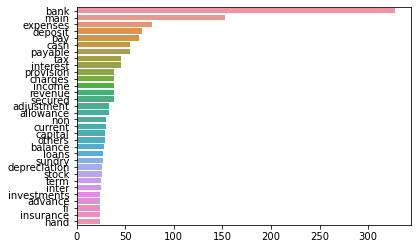

In [15]:
lst_stopwords = nltk.corpus.stopwords.words("english")

counter=Counter(vocab)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in lst_stopwords) :
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

In [16]:

corpus = cleantrain['UserGLDescription']  
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

In [17]:
print(len(tokenizer_obj.word_counts))

max_length = 20
X = pad_sequences(sequences, maxlen=max_length, padding = 'post')

1715


In [18]:
vocab_size = len(tokenizer_obj.word_counts) + 1
X.shape


(1869, 20)

In [19]:
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam

Using TensorFlow backend.


In [20]:
y_target = cleantrain['combinedCol']

In [21]:
y_target[:1]

5    BS_GROUP->BS_NetAssets->BS_Assets->BS_NCurrAss...
Name: combinedCol, dtype: object

In [22]:
myset = set(y_target)
output_size = len(myset)
output_size

74

In [23]:
integer_mapping_set = {x: i for i,x in enumerate(myset)}
vec = [integer_mapping_set[word] for word in y_target]

In [24]:
y = np_utils.to_categorical(y = vec)

In [25]:
print(y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [26]:
y.shape

(1869, 74)

In [27]:
#print(X_train.shape)
#print(y_train.shape)
#print(X_test.shape)
#print(y_test.shape)

In [28]:
vec_size = 300
model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(output_size, activation='softmax'))

In [29]:
model.compile(optimizer=Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(X, y, epochs = 100,  shuffle = True)

Train on 1869 samples
Epoch 1/100
1869/1869 [==============================] - 3s 1ms/sample - loss: 3.8154 - accuracy: 0.1990
Epoch 2/100
1869/1869 [==============================] - 1s 671us/sample - loss: 2.9966 - accuracy: 0.2825 - los
Epoch 3/100
1869/1869 [==============================] - 1s 749us/sample - loss: 2.6953 - accuracy: 0.3526 - loss: 2.7496 
Epoch 4/100
1869/1869 [==============================] - 1s 657us/sample - loss: 2.3134 - accuracy: 0.4238
Epoch 5/100
1869/1869 [==============================] - 1s 649us/sample - loss: 1.9005 - accuracy: 0.5383
Epoch 6/100
1869/1869 [==============================] - 1s 726us/sample - loss: 1.5564 - accuracy: 0.6362
Epoch 7/100
1869/1869 [==============================] - 1s 661us/sample - loss: 1.3154 - accuracy: 0.6816
Epoch 8/100
1869/1869 [==============================] - 1s 693us/sample - loss: 1.0852 - accuracy: 0.7223 - loss: 1.0817 - accuracy: 0.
Epoch 9/100
1869/1869 [==============================] - 1s 697us/sample

1869/1869 [==============================] - 1s 694us/sample - loss: 0.0704 - accuracy: 0.9722
Epoch 75/100
1869/1869 [==============================] - 1s 748us/sample - loss: 0.0758 - accuracy: 0.9706
Epoch 76/100
1869/1869 [==============================] - 1s 736us/sample - loss: 0.0746 - accuracy: 0.9716
Epoch 77/100
1869/1869 [==============================] - 1s 669us/sample - loss: 0.0721 - accuracy: 0.9727
Epoch 78/100
1869/1869 [==============================] - 1s 645us/sample - loss: 0.0758 - accuracy: 0.9679
Epoch 79/100
1869/1869 [==============================] - 1s 608us/sample - loss: 0.0766 - accuracy: 0.9716
Epoch 80/100
1869/1869 [==============================] - 1s 639us/sample - loss: 0.0758 - accuracy: 0.9727 - loss: 0.0761 - accuracy: 0.97
Epoch 81/100
1869/1869 [==============================] - 1s 626us/sample - loss: 0.0716 - accuracy: 0.9738
Epoch 82/100
1869/1869 [==============================] - 1s 645us/sample - loss: 0.0773 - accuracy: 0.9684
Epoch 83/

In [36]:
def get_encoded(x): 
  x= utils_preprocess_text(x)
  x = tokenizer_obj.texts_to_sequences([x])
  x = pad_sequences(x, maxlen=max_length, padding = 'post')
  return x

In [53]:
x='Acc. Depreciation-Computer Software'
print('User GL description: '+ x)
expectedFolder = cleantrain.loc[cleantrain['UserGLDescription'] == utils_preprocess_text('Acc. Depreciation-Computer Software')]
pd.options.display.max_colwidth = 100 # stop string truncation
print('Expected path: ' + expectedFolder['combinedCol'].to_string(index=False))
pred_vector = model.predict(get_encoded(x))
confidence = np.max(pred_vector)
if(confidence >= .5):    
    result_vector=np.argmax(pred_vector, axis=-1)
    for key, val in integer_mapping_set.items():
        if val == result_vector:
             print('predicted path: '+ key)
else:
    print("Can't say")


User GL description: Acc. Depreciation-Computer Software
Expected path:  BS_GROUP->BS_NetAssets->BS_Assets->BS_NCurrAssets->BS_Intang->BS_IntangOth->BS_IntangACS
predicted path: BS_GROUP->BS_NetAssets->BS_Assets->BS_NCurrAssets->BS_Intang->BS_IntangOth->BS_IntangACS


In [32]:
Yhat = np.argmax(model.predict(X), axis=-1)

In [33]:
Yhat

array([33,  4,  4, ..., 44, 44, 44], dtype=int64)

In [34]:

from sklearn.metrics import classification_report,confusion_matrix

In [35]:
#print(confusion_matrix(vec,Yhat))
classNames = list(integer_mapping_set.keys())
classNames[:] = (elem[-10:] for elem in classNames)
classNames
print(classification_report(vec,Yhat,target_names = classNames))

              precision    recall  f1-score   support

  ->E5259000       1.00      1.00      1.00         1
  S_WagesSal       0.90      0.93      0.92        60
  ->E2879100       0.90      1.00      0.95         9
  therRev3rd       1.00      1.00      1.00         2
  _IntangACS       1.00      1.00      1.00         8
  _InvestGrp       1.00      1.00      1.00        21
  _LT_AR_3rd       1.00      1.00      1.00         4
  _ST_AR_3rd       1.00      1.00      1.00        26
  ->E2879100       1.00      1.00      1.00         1
  ->E2879100       1.00      1.00      1.00        50
  S_Sales3rd       1.00      1.00      1.00        36
  CashDefBen       1.00      1.00      1.00         2
  _OthInvest       1.00      1.00      1.00         1
  therRevGrp       1.00      0.96      0.98        23
  E_Building       1.00      1.00      1.00        10
  ->E2879100       1.00      1.00      1.00        18
  CashDefBen       1.00      1.00      1.00         2
  ->BS_LT_AR       0.97    